Import data

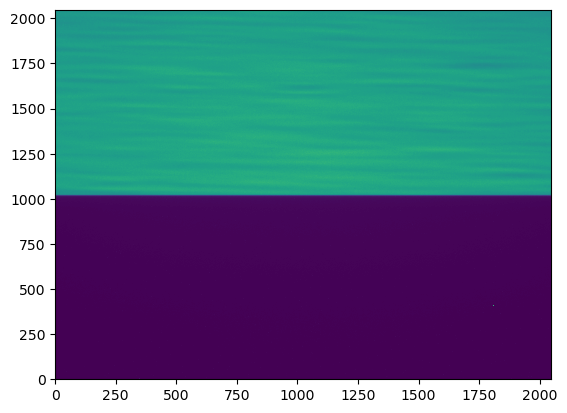

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data_input_object = np.loadtxt("PSF_spool_1.asc").T[1::] / 30 # нормировка на 1 сек
data_input_source = np.loadtxt("PSF_spool_2.asc").T[1::] / 30
plt.pcolormesh(data_input_object)
plt.show()

Data filtering + nan_mean

In [ ]:
1.44 / 0.325

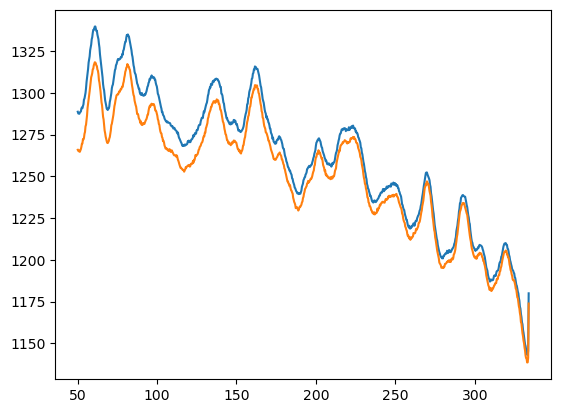

In [2]:
dx_input = 0.325
dy_input = 0.325
Nx, Ny = data_input_object.shape
x_input = np.linspace(0, Nx*dx_input, Nx)
y_input = np.linspace(0, Ny*dy_input, Ny)
x_input -= x_input[1024]
y_input -= y_input[1020]

XX, YY = np.meshgrid(x_input, y_input)
data_input_object[data_input_object>1467] = np.nan
data_input_object[(YY<-10) & (data_input_object > 100)] = np.nan
data_input_object_mean = np.nanmean(data_input_object, axis=1)


data_input_source[data_input_source>1480] = np.nan

data_input_source_mean = np.nanmean(data_input_source, axis=1)
# plt.plot(YY, data_input)

plt.plot(y_input[y_input>50], data_input_source_mean[y_input>50])
plt.plot(y_input[y_input>50], data_input_object_mean[y_input>50]);

Approx I* = I*k + b

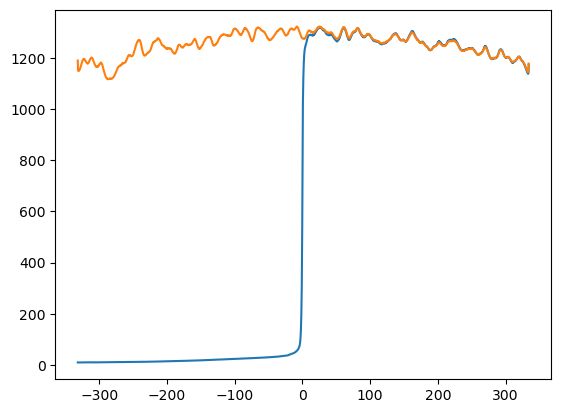

In [3]:
from scipy.stats import linregress

def find_k_and_b(data, approx_data):
  """
  Находит параметры k и b для аппроксимации approx_data = k*data + b,
  используя метод наименьших квадратов.

  Args:
    data: 1D массив NumPy, представляющий исходные данные.
    approx_data: 1D массив NumPy, представляющий аппроксимированные данные.

  Returns:
    tuple: (k, b) - параметры аппроксимации.  Возвращает None, если ошибка.
  """

  if len(data) != len(approx_data):
    print("Ошибка: Длина массивов data и approx_data должна быть одинаковой.")
    return None

  # Используем метод наименьших квадратов для нахождения k и b.
  # Решаем систему уравнений:
  # sum(approx_data) = k * sum(data) + b * N
  # sum(data * approx_data) = k * sum(data^2) + b * sum(data)
  # где N - количество точек данных.

  n = len(data)
  sum_data = np.sum(data)
  sum_approx_data = np.sum(approx_data)
  sum_data_squared = np.sum(data**2)
  sum_data_approx = np.sum(data * approx_data)

  # Решаем систему уравнений относительно k и b
  # Используем numpy.linalg.solve для решения системы линейных уравнений
  A = np.array([[sum_data, n], [sum_data_squared, sum_data]])
  B = np.array([sum_approx_data, sum_data_approx])

  try:
      x = np.linalg.solve(A, B)
      k, b = x[0], x[1]
      return k, b
  except np.linalg.LinAlgError:
      print("Ошибка: Невозможно решить систему линейных уравнений.  Возможно, данные линейно зависимы.")
      return None


k, b = find_k_and_b(data_input_source_mean[y_input>50], data_input_object_mean[y_input>50])

plt.plot(y_input, data_input_object_mean)
plt.plot(y_input, k*data_input_source_mean+b)

(-25.0, 25.0)

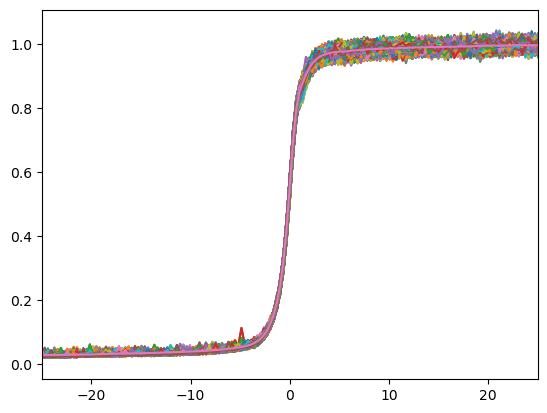

In [4]:
%matplotlib inline
data_input = data_input_object/(k*data_input_source+b)
plt.plot(y_input, data_input)
data_input_mean = np.nanmean(data_input, axis=1)
plt.plot(y_input, data_input)
plt.plot(y_input, data_input_mean)
plt.xlim(-25, 25)

Text(0, 0.5, 'y, µm')

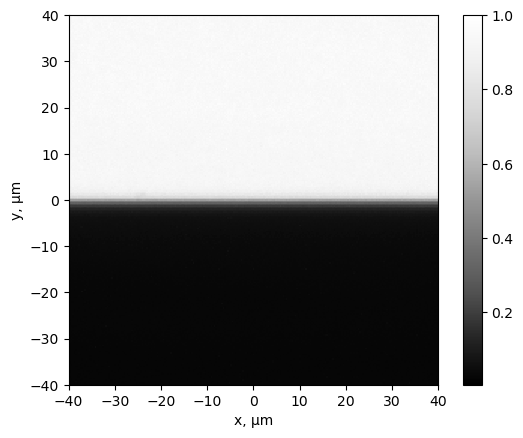

In [5]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ccc = ax.pcolormesh(x_input, y_input, data_input/np.nanmax(data_input), cmap="Greys_r")
plt.colorbar(ccc)
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.xlabel("x, µm")
plt.ylabel("y, µm")

In [6]:
mean_low = np.nanmean(data_input[(YY > -15) & (YY < -10)])
mean_high = np.nanmean(data_input[(YY > 10) & (YY < 15)])

var_low = np.nanvar(data_input[YY < -10])
var_high = np.nanvar(data_input[YY > 5])

print(mean_high, mean_low)
print(np.sqrt(var_high), np.sqrt(var_low))

0.9896302971755613 0.036098733207442495
0.011261889237091104 0.006633101135450175


(-25.0, 25.0)

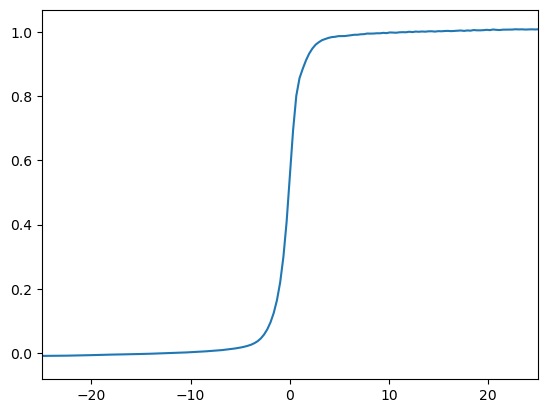

In [7]:
data_input_norm = (data_input_mean - mean_low)/(mean_high-mean_low)
# data_input_norm = data_input_mean
plt.plot(y_input, data_input_norm)
# plt.plot(y_input-1.5, 1-data_input_norm[::-1])
# plt.scatter(y_input, data_input_norm, facecolors='none', edgecolors='r', s=10)
# plt.scatter(y_input, 1 - data_input_norm[::-1], facecolors='none', edgecolors='r', s=10)
plt.xlim(-25, 25)

0.9685266012212655 -0.1514900888936176


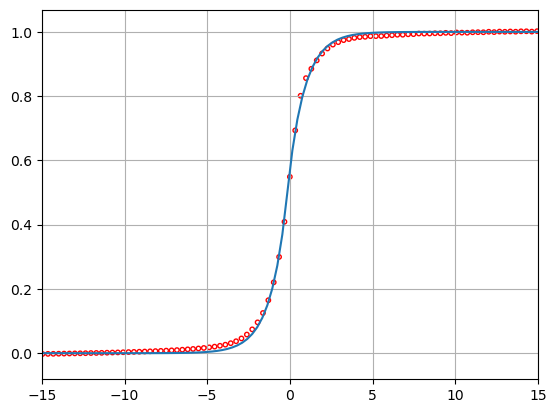

In [11]:
def laplace_cdf(x, a, b):
    x = x - b
    left = 1/2 * np.exp(a*x)
    left[x>=0] = 0
    right = 1 - 1/2 * np.exp(-a*x)
    right[x<0] = 0
    return left + right

# %matplotlib tk

# def laplace_cdf(x, a):
#     return 1 / np.pi * np.arctan(x/a) + 1/2

from scipy.optimize import curve_fit

y_edge = 15

plt.scatter(y_input, data_input_norm, label="filtered ESF", facecolors='none', edgecolors='r', s=10)


[a, b], res1 = curve_fit(lambda x_psf, a, b: laplace_cdf(x_psf, a, b), y_input[abs(y_input)<y_edge], data_input_norm[abs(y_input)<y_edge])

# a_cdf = a

y_fit = np.linspace(-15, 15, 100)
plt.plot(y_fit, laplace_cdf(y_fit, 1, b), label=f"fit ESF laplace (param = {a:1.3})")



# plt.ylabel("ESF(y)")
# plt.xlabel("y, µm")
plt.grid()

# plt.legend()
plt.xlim(-15, 15)
plt.savefig(f"ESF.png", bbox_inches='tight', pad_inches=0, dpi=400)
print(a, b)

0.9685266012212655 -0.1514900888936176


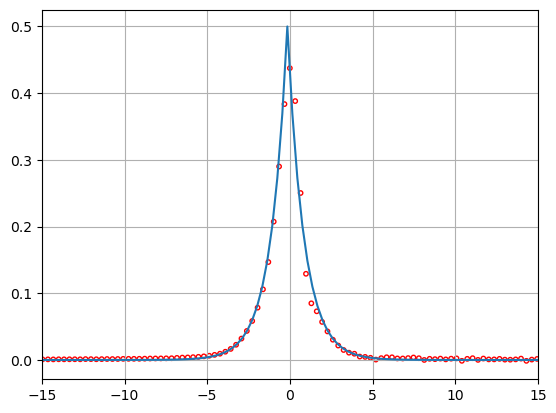

In [12]:
from scipy.optimize import curve_fit

# lsf_exper = wiener_deconvolution_1d(data_interp_slice, data_ideal[:, slice_idx], err=1.11, dx=dy_interp)
# lsf_exper[abs(y_interp)>11.75] = 0
# print(f"Проверка суммы lsf на 1 == {np.sum(lsf_exper)*dy_interp}")
# plt.plot(y_interp, lsf_exper, label='experiment')

def laplace_1d(x, a, b):
    x = x - b
    body = np.exp(-a*abs(x))
    A = a / 2
    return A * body

# [a], res1 = curve_fit(lambda x_psf, a: laplace_1d(x_psf, a), y_interp, lsf_exper)

# a_deconv = a

# %matplotlib tk
LSF_grad = np.gradient(data_input_norm, dy_input, edge_order=0)
plt.scatter(y_input, LSF_grad, label="filtered ESF", facecolors='none', edgecolors='r', s=10)

# [a, b], res1 = curve_fit(lambda x_psf, a, b: laplace_1d(x_psf, a, b), y_input[abs(y_input)<15], LSF_grad[abs(y_input)<15])

y_fit = np.linspace(-15, 15, 100)
plt.plot(y_fit, laplace_1d(y_fit, 1, b), label=f"fit LSF deconv (param = {a:1.3})")

# plt.plot(y_interp, laplace_1d(y_interp, a_cdf), label=f"fit LSF laplace (param = {a_cdf:1.3})")
# plt.ylabel("LSF(y)")
# plt.xlabel("y, µm")
plt.xlim(-15, 15)
# plt.legend()
plt.grid()
print(a, b)
plt.savefig(f"LSF.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

Deconvolution methods initialization

In [1]:
import sys
sys.path.append('../')
import opticaldevicelib_1d as od_1d
import cupy as cp

fft = od_1d.OpticalDevice.ft1d
ifft = od_1d.OpticalDevice.ift1d

def wiener_deconvolution_1d(signal, kernel, err, dx):
	"lambd is the SNR"
	# kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
	H = fft(kernel, dx)
	deconvolved = ifft(fft(signal, dx)*np.conj(H)/(H*np.conj(H) + err**2), dx)
	return deconvolved.real


def convolution_1d(signal, kernel, dx):
    G = fft(signal, dx)
    H = fft(kernel, dx)
    deconvolved = ifft(G * H, dx)
    return deconvolved.real

def nearest_elem_index(elem, data):
    idx = np.where(data == data.flat[np.abs(data -  elem).argmin()])[0][0]
    print(f"nearest elem is {data[idx]}")
    return idx

import opticaldevicelib_2d as od_2d
fft2d = od_2d.OpticalDevice.ft2d
ifft2d = od_2d.OpticalDevice.ift2d

# fft2d = cp.fft.fft2
# ifft2d = cp.fft.ifft2

def laplace(x, y, a, b, c):
    X, Y = np.meshgrid(x, y)
    # alpha = np.sqrt(sig_x**2+sig_y**2)
    return np.exp(-a*np.sqrt(X**2+Y**2)**b+c)

def lorenz_2d(x, y, sig_x, sig_y):
    X, Y = np.meshgrid(x, y)
    return 1 / (2 * np.pi * sig_x * sig_y * (1 + (X/sig_x)**2 + (Y/sig_y)**2)**(3/2))


def gauss_2d(x, y, sig_x, sig_y):
    X, Y = np.meshgrid(x, y)
    return  np.exp(-(X/sig_x)**2/2 - (Y/sig_y)**2/2) / (2 * np.pi * sig_x * sig_y)

def square_2d(x, y, sig):
    dx = x[0, 1] - x[0, 0]
    dy = y[1, 0] - y[0, 0]
    di = sig / dx
    dj = sig / dy
    i, j = x.shape
    print(dx, dy)
    arr = np.zeros(shape=(i, j))
    arr[int((i-di)//2) : int((i+di)//2), int((j-dj)//2) : int((j+dj)//2)] = 1
    return arr

def wiener_deconvolution_2d(signal, kernel, err, v, dx, dy):
    signal = cp.array(signal)
    kernel = cp.array(kernel)
    err = cp.array(err)
    signal_padded = np.pad(signal, ((v, v), (v, v)), 'edge')
    kernel_padded = np.pad(kernel, ((v, v), (v, v)), 'edge')
    err_padded = np.pad(err, ((v, v), (v, v)), 'edge')
    # print(type(signal_padded))
    H = fft2d(kernel_padded, dx, dy)
    deconvolved = ifft2d(fft2d(signal_padded, dx, dy) * np.conj(H) / (H*np.conj(H) + err_padded**2), dx, dy)
    deconvolved = deconvolved[v:-v, v:-v]
    return deconvolved.real

def deconvolution_2d(signal, kernel, dx, dy):
    G = fft2d(signal, dx, dy)
    H = fft2d(kernel, dx, dy)
    deconvolved = ifft2d(G/H, dx, dy)
    return deconvolved.real

def convolution_2d(signal, kernel, v, dx, dy):

    signal_padded = np.pad(signal, ((v, v), (v, v)), 'edge')
    kernel_padded = np.pad(kernel, ((v, v), (v, v)), 'edge')

    G = fft2d(signal_padded, dx, dy)
    H = fft2d(kernel_padded, dx, dy)

    convolved = ifft2d(G * H, dx, dy)
    convolved = convolved[v:-v, v:-v]
    return convolved.real

def rl_deconv(signal, psf, bg, v, dx, dy, N_iter=None, dff=None):
    # signal = cp.array(signal)
    # psf = cp.array(psf)
    f = cp.ones(signal.shape) * 0.5

    if dff == None and N_iter != None:
        for i in range(N_iter):
            f0 = f.copy()
            ratt = signal / (convolution_2d(psf, f, v, dx, dy) + bg)
            
            f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
            stopper = np.sum(abs(f0-f))/np.sum(f)
            
            if i % 20 == 0:
                print(f"i = {i}, df/f = {stopper:1.4}")

    elif N_iter == None and dff != None:
        ii = 0
        stopper = dff + 1
        while stopper >= dff and ii < 500:
            f0 = f.copy()
            ratt = signal / (convolution_2d(psf, f, v, dx, dy) + bg)
            f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
            stopper = np.sum(abs(f0-f))/np.sum(f0)
            if ii % 20 == 0:
                print(f"i = {ii}, df/f = {stopper:1.4}")
            ii += 1

    return f


def rl_blind_deconv(signal, psf, N_iter, lamTV, k, v, dx, dy):
    eps = 1e-12
    # im_deconv = np.full(image.shape, 0.1, dtype='float')    # init output
    signal = cp.array(signal)
    psf = cp.array(psf)
    f = cp.ones(signal.shape) * 0.1
    for i in range(N_iter):

        if i % 5 == 0:
            f0 = f.copy()

        grad_x_f = np.gradient(f, dx, axis=0)
        grad_y_f = np.gradient(f, dy, axis=1)
        norm_grad_f = np.sqrt(grad_x_f**2 + grad_y_f**2) + eps
        grgr_x = np.gradient(grad_x_f, dx, axis=0)
        grgr_y = np.gradient(grad_y_f, dy, axis=1)
        reg_rel = 1 / (1 - lamTV*(grgr_y + grgr_x))

        MTF = lamTV * (grgr_x + grgr_y) / (1 + (norm_grad_f/k)**2)

        tikh_rel = 1 / (1 - MTF)

        relative_blur = signal / (convolution_2d(f, psf, v, dx, dy) + eps)
        f *= convolution_2d(relative_blur, cp.flip(psf), v, dx, dy)
        # f = f / cp.sum(f)
        psf *= convolution_2d(relative_blur, cp.flip(f), v, dx, dy) * tikh_rel

        if i % 5 == 0: 
            print(f"iter = {i}, df/f = {100*(np.sum(abs(f0-f))/np.sum(f0)):1.3} %")
            
    return f


GPU is available!
GPU is available!


In [2]:
def div_grad(arr, hx, hy):

    eps = 1e-12

    def grad_x_plus(arr, hx):
        y_len, x_len = arr.shape
        result = cp.empty(shape=(y_len, x_len))
        for i in range(x_len):
            if i != x_len-1:
                result[:, i] = (arr[:, i+1] - arr[:, i]) / hx
            else:
                result[:, i] = result[:, i-1]
        return result

    def grad_x_minus(arr, hx):
        y_len, x_len = arr.shape
        result = cp.empty(shape=(y_len, x_len))
        for i in range(x_len-1, -1, -1):
            if i != 0:
                result[:, i] = (arr[:, i] - arr[:, i-1]) / hx
            else:
                result[:, i] = result[:, i+1]
        return result

    def grad_y_plus(arr, hy):
        y_len, x_len = arr.shape
        result = cp.empty(shape=(y_len, x_len))
        for j in range(y_len):
            if j != y_len-1:
                result[j, :] = (arr[j+1, :] - arr[j, :]) / hy
            else:
                result[j, :] = result[j-1, :]
        return result

    def grad_y_minus(arr, hy):
        y_len, x_len = arr.shape
        result = cp.empty(shape=(y_len, x_len))
        for j in range(y_len-1, -1, -1):
            if j != 0:
                result[j, :] = (arr[j, :] - arr[j-1, :]) / hy
            else:
                result[j, :] = result[j+1, :]
        return result

    def m_foo(a, b):
        return (np.sign(a) + np.sign(b)) / 2 * np.minimum(abs(a), abs(b))

    x_norm = np.sqrt(eps**2 + (grad_x_plus(arr, hx)) ** 2 + (m_foo(grad_y_plus(arr, hy), grad_y_minus(arr, hy))) ** 2)
    x_part = 1 / hx * grad_x_minus(grad_x_plus(arr, hx) / x_norm, hx)
    
    y_norm = np.sqrt(eps**2 + (grad_y_plus(arr, hy)) ** 2 + (m_foo(grad_x_plus(arr, hx), grad_x_minus(arr, hx))) ** 2)
    y_part = 1 / hy * grad_y_minus(grad_y_plus(arr, hy) / y_norm, hy)

    return x_part + y_part

def rl_deconv_tv(signal, psf, bg, N_iter, lamTV, v, dx, dy):
    signal = cp.array(signal)
    psf = cp.array(psf)
    # f = np.ones(shape=signal.shape)
    # f = signal / signal * 0.5
    f = cp.ones(signal.shape) * 0.5

    for i in range(N_iter):

        f0 = f.copy()

        ratt = signal / (convolution_2d(psf, f, v, dx, dy) + bg)

        reg_rel = 1 / (1 - lamTV * div_grad(f, dx, dy))

        # # f += dt * (-1 + lamTV*(grgr_y + grgr_x) + convolution_2d(cp.flip(psf), ratt, v, dx, dy))
        # f += dt * (-1 + convolution_2d(cp.flip(psf), ratt, v, dx, dy))

        if i == 0:
            reg_rel = 1
        
        f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy) * reg_rel
        # f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
        

        # print(np.sum(abs(f0-f))/np.sum(f)) 
        print(f"iter = {i}, df/f = {100*(np.sum(abs(f0-f))/np.sum(f0)):1.3} %")

        # plt.pcolormesh((f-signal).get())
        # plt.show()

    return f


def rl_deconv_tv_add(signal, psf, N_iter, lamTV, dt, v, dx, dy):
    eps = 1e-12
    signal = cp.array(signal)
    psf = cp.array(psf)
    # f = np.ones(shape=signal.shape)
    # f = signal / signal * 0.5
    f = cp.ones(signal.shape) * 0.5

    for i in range(N_iter):

        f0 = f.copy()

        ratt = signal / (convolution_2d(psf, f, v, dx, dy) + eps)


        f += dt * (-1 + lamTV*div_grad(f, dx, dy) + convolution_2d(cp.flip(psf), ratt, v, dx, dy))
        # f += dt * (-1 + convolution_2d(cp.flip(psf), ratt, v, dx, dy))

        
        f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
        # f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
        

        # print(np.sum(abs(f0-f))/np.sum(f)) 
        print(f"iter = {i}, df/f = {100*(np.sum(abs(f0-f))/np.sum(f0)):1.3} %")

        # plt.pcolormesh((f-signal).get())
        # plt.show()

    return f


PSF testing

Test data

In [23]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

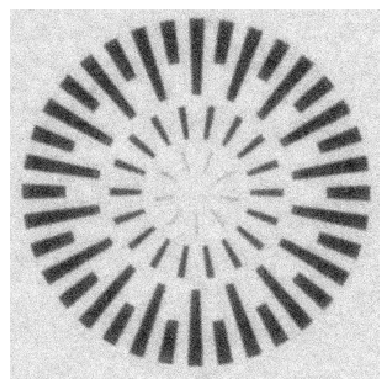

In [24]:
data_input_test = np.loadtxt("test_input/data__.asc") # нормирован на паттерн источника
%matplotlib inline

# data_input_test = np.max(data_input_test) - data_input_test # reverse

dx_input_test = 0.325
dy_input_test = 0.325
Nx, Ny = data_input_test.shape
x_input_test = np.linspace(0, Nx*dx_input_test, Nx)
y_input_test = np.linspace(0, Ny*dy_input_test, Ny)
x_input_test -= x_input_test[512]
y_input_test -= y_input_test[512]

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')

idx_cut = 150

x_input_test = x_input_test[512-idx_cut : 512+idx_cut]
y_input_test = y_input_test[512-idx_cut : 512+idx_cut]
data_input_test = data_input_test[512-idx_cut : 512+idx_cut, 512-idx_cut : 512+idx_cut]
plt.pcolormesh(x_input_test, y_input_test, data_input_test, cmap="Greys_r")
# colbar = plt.pcolormesh(x_input_test, y_input_test, data_input_test/np.max(data_input_test), cmap='Greys_r')
# cbar = fig.colorbar(colbar)
plt.axis("off")
plt.savefig(f"raw_data.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

In [ ]:
plt.plot(data_input_test);

In [ ]:
print(np.mean(data_input_test[data_input_test<0.06]))

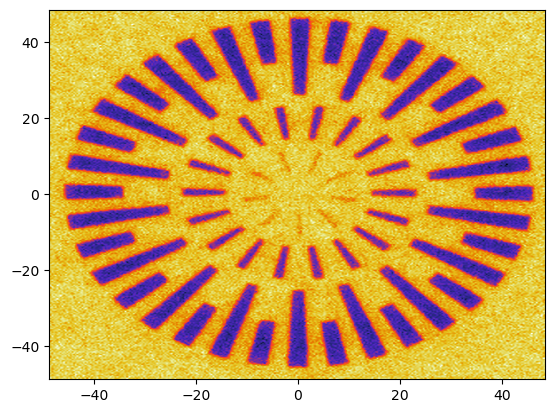

In [25]:
x_cut_test = x_input_test
y_cut_test = y_input_test

data_cut_test = data_input_test

from scipy.interpolate import RegularGridInterpolator

N_interp_test = 2**11
data_interp_test = np.empty(shape=(N_interp_test, N_interp_test))

y_test = np.linspace(x_cut_test[0], x_cut_test[-1], N_interp_test)
x_test = np.linspace(y_cut_test[0], y_cut_test[-1], N_interp_test)

dx_test = x_test[1] - x_test[0]
dy_test = y_test[1] - y_test[0]

interp_test = RegularGridInterpolator((y_cut_test, x_cut_test), data_cut_test, method="cubic", bounds_error=False, fill_value=None)

data_interp_test = interp_test((np.meshgrid(y_test, x_test, indexing='ij')))
%matplotlib inline
plt.pcolormesh(x_test, y_test, data_interp_test, cmap="CMRmap")

Text(0, 0.5, 'y, µm')

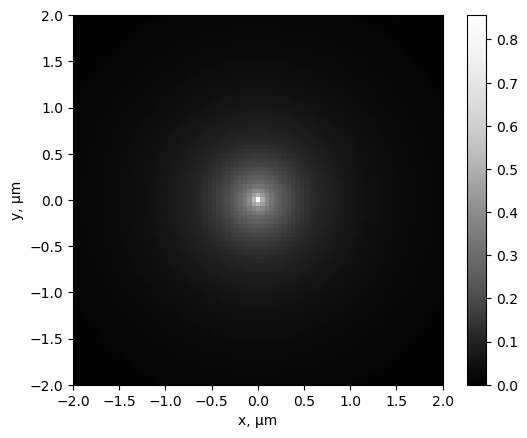

In [31]:
from scipy.special import kv

def psf_McDonald(x, y, a):
    X, Y = np.meshgrid(x, y)
    return a**2 / (2*np.pi) * kv(0, a*np.sqrt(X**2+Y**2))

psf_analyt = psf_McDonald(x_test, y_test, 1)

# print(np.sum(psf_analyt)*dx_test*dy_test)
# plt.pcolormesh(x_test, y_test, psf_analyt)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

fig, ax = plt.subplots()
ax.set_aspect('equal')

ccc = ax.pcolormesh(x_test, y_test, psf_analyt, cmap="Greys_r")
plt.colorbar(ccc)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("x, µm")
plt.ylabel("y, µm")

In [55]:
# data_rl_test = rl_deconv_tv(signal=cp.array(data_interp_test), psf=cp.array(psf_analyt), bg=1e-12, N_iter=30, lamTV=5e-6, v=200, dx=dx_test, dy=dy_test)
data_rl_test = rl_deconv(signal=cp.array(data_interp_test), psf=cp.array(psf_analyt), bg=1e-12, dff=4e-4, v=400, dx=dx_test, dy=dy_test)
data_rl_test = data_rl_test.get()

i = 0, df/f = 0.9343
i = 20, df/f = 0.0006977
i = 40, df/f = 0.0004542


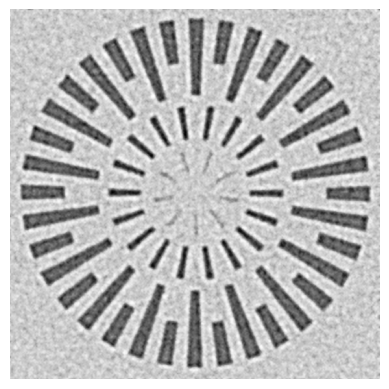

In [57]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
plt.pcolormesh(x_test, y_test, data_rl_test, cmap="Greys_r")
plt.axis("off")
plt.savefig(f"deconv_data.png", bbox_inches='tight', pad_inches=0, dpi=400)
# colbar = plt.pcolormesh(x_test, y_test, data_rl_test, cmap='Greys_r')
# cbar = fig.colorbar(colbar)
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)

nearest elem is 0.0036552549781916355
nearest elem is 0.0036552549781916355


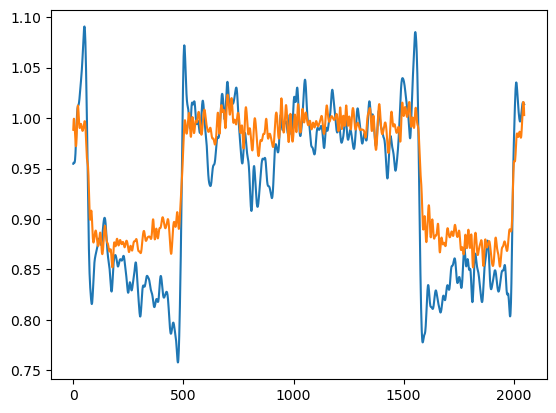

In [56]:
plt.plot(data_rl_test[:, nearest_elem_index(0, y_test)])
plt.plot(data_interp_test[:, nearest_elem_index(0, y_test)])

In [ ]:
plt.pcolormesh(x_test, y_test, data_interp_test, cmap="Greys_r")
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)

In [ ]:
plt.plot(y_test, np.mean(data_interp_test, axis=1))
plt.plot(y_test, np.mean(data_rl_test, axis=1))
ideal_step = y_test.copy()
ideal_step[y_test<0] = 0
ideal_step[y_test>=0] = 1300
plt.plot(y_test, ideal_step)

SAVE DATA TO IMPORT

In [ ]:
import os
import numpy as np

def cache_res(folder, model_name):
    os.makedirs(f"{folder}/{model_name}", exist_ok=True)
    np.save(f"{folder}/{model_name}/x", x_interp)
    np.save(f"{folder}/{model_name}/y", y_interp)
    np.save(f"{folder}/{model_name}/psf", circle_deconv_psf)

cache_res("ftian_cache", "PSF")

In [ ]:
def read_res(folder, model_name):
    x = np.load(f"{folder}/{model_name}/x.npy")
    y = np.load(f"{folder}/{model_name}/y.npy")
    psf = np.load(f"{folder}/{model_name}/psf.npy")
    
    return x, y, psf

read_res("ftian_cache", "PSF")